# Week 2: Tackle Overfitting with Data Augmentation

In [24]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [25]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-06-17 14:06:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.97.45.22, 2600:1409:9800:98c::317f, 2600:1409:9800:984::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.97.45.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   272MB/s    in 2.9s    

2023-06-17 14:06:48 (272 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [26]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [31]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and validation sets

  Args:
    root_path (string): the base directory path to create subdirectories from

  Returns:
    None
  """

  # Create train and validation directories using os.makedirs
  train_dir = os.path.join(root_path, 'training')
  validation_dir = os.path.join(root_path, 'validation')

  os.makedirs(train_dir)
  os.makedirs(validation_dir)

  # Create subdirectories for 'cats' and 'dogs' within train and validation directories
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')

  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)
  os.makedirs(validation_cats_dir)
  os.makedirs(validation_dogs_dir)

### START CODE HERE

# Call the create_train_val_dirs function
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

### END CODE HERE


In [32]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [34]:
import os
import random
from shutil import copyfile

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and validation sets

    Args:
        SOURCE_DIR (string): directory path containing the images
        TRAINING_DIR (string): directory path to be used for training
        VALIDATION_DIR (string): directory path to be used for validation
        SPLIT_SIZE (float): proportion of the dataset to be used for training

    Returns:
        None
    """
    # Get the list of files in the source directory
    files = os.listdir(SOURCE_DIR)

    # Shuffle the files randomly
    random.shuffle(files)

    # Calculate the split index based on the split size
    split_index = int(SPLIT_SIZE * len(files))

    # Split the files into training and validation sets
    training_files = files[:split_index]
    validation_files = files[split_index:]

    # Copy the training files to the training directory
    for file in training_files:
        source_file = os.path.join(SOURCE_DIR, file)
        destination_file = os.path.join(TRAINING_DIR, file)

        # Check if the file has non-zero length before copying
        if os.path.getsize(source_file) > 0:
            copyfile(source_file, destination_file)
        else:
            print(f"{file} is zero length, so ignoring.")

    # Copy the validation files to the validation directory
    for file in validation_files:
        source_file = os.path.join(SOURCE_DIR, file)
        destination_file = os.path.join(VALIDATION_DIR, file)

        # Check if the file has non-zero length before copying
        if os.path.getsize(source_file) > 0:
            copyfile(source_file, destination_file)
        else:
            print(f"{file} is zero length, so ignoring.")



In [35]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [36]:
from keras.preprocessing.image import ImageDataGenerator

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators

    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class for training data
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Generate batches of augmented training data
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    # Instantiate the ImageDataGenerator class for validation data
    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Generate batches of validation data
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator


In [37]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# GRADED FUNCTION: create_model
def create_model():
    # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
    # USE AT LEAST 3 CONVOLUTION LAYERS

    model = tf.keras.models.Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),

        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third convolutional layer
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten the feature maps
        Flatten(),

        # Fully connected layers
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [39]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
214/704 [========>.....................] - ETA: 56s - loss: 0.6719 - accuracy: 0.6186

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


704/704 [==============================] - 101s 125ms/step - loss: 0.5715 - accuracy: 0.7008 - val_loss: 0.5128 - val_accuracy: 0.7484
Epoch 2/15
704/704 [==============================] - 87s 123ms/step - loss: 0.4449 - accuracy: 0.7902 - val_loss: 0.4962 - val_accuracy: 0.7628
Epoch 3/15
704/704 [==============================] - 86s 122ms/step - loss: 0.3692 - accuracy: 0.8345 - val_loss: 0.3994 - val_accuracy: 0.8164
Epoch 4/15
704/704 [==============================] - 86s 122ms/step - loss: 0.2902 - accuracy: 0.8763 - val_loss: 0.4071 - val_accuracy: 0.8244
Epoch 5/15
704/704 [==============================] - 86s 122ms/step - loss: 0.1969 - accuracy: 0.9227 - val_loss: 0.4124 - val_accuracy: 0.8328
Epoch 6/15
704/704 [==============================] - 86s 122ms/step - loss: 0.1064 - accuracy: 0.9606 - val_loss: 0.5461 - val_accuracy: 0.8396
Epoch 7/15
704/704 [==============================] - 85s 120ms/step - loss: 0.0613 - accuracy: 0.9779 - val_loss: 0.6827 - val_accuracy: 0.

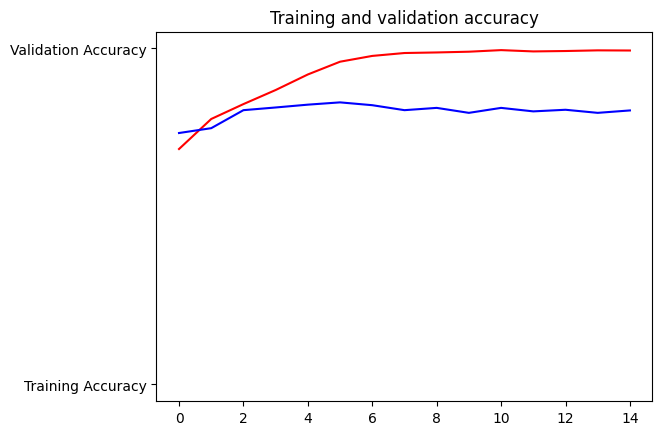

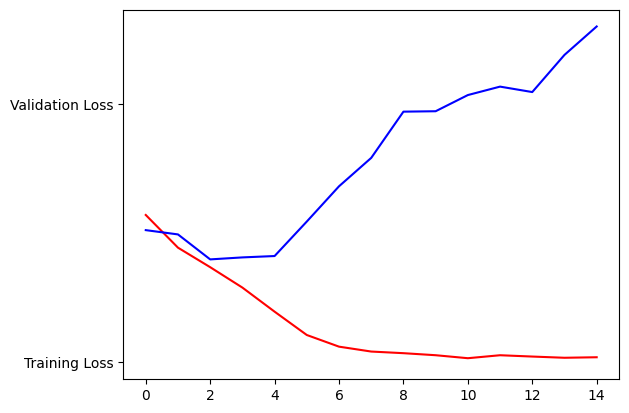

In [40]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [41]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>